In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
from sklearn.pipeline import Pipeline

In [4]:
from feature_engineering.time_features import TimeFeatures
from feature_engineering.price_features import PriceFeatures

# Import data

In [5]:
data_test = pd.read_excel("Validation_Data.xlsx")
data_test_ = data_test.drop(columns=["Forecasted Units"])
data_test_

,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,DAILY_UNITS
0,23,2022-08-06,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,?,Moderate,3
1,100,2022-08-02,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,16.99,Fully-Stocked,2
2,121,2022-08-06,MISC ACCY,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,24.99,?,?,Fully-Stocked,6
3,207,2022-08-03,OTR MIC,OTR MICROWAVE,ML - Kitchen,VP - Major Appliances,499.99,?,?,Fully-Stocked,0
4,416,2022-08-05,AMPS,CAR STEREO,ML - Connected Car,VP - Electrify & Car,269.99,?,?,Fully-Stocked,9
...,...,...,...,...,...,...,...,...,...,...,...
3768,486,2022-08-06,SO CAR ACCESSORIES,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,?,Fully-Stocked,2
3769,171,2022-08-02,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,?,Fully-Stocked,1
3770,258,2022-08-01,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,?,Fully-Stocked,0
3771,140,2022-08-01,DISHWASHER,DISHWASHERS,ML - Kitchen,VP - Major Appliances,566.99,?,629,Moderate,1


In [6]:
data_train = pd.read_excel("HackathonData.xlsx")
data_train


,Encoded_SKU_ID,SALES_DATE,SUBCLASS_NAME,CLASS_NAME,ML_NAME,CATEGORY_NAME,RETAIL_PRICE,PROMO_PRICE,COMPETITOR_PRICE,Inventory,DAILY_UNITS
0,1,2017-09-28,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,1
1,2,2017-11-24,CAMERA BATTERIES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,39.99,?,?,Fully-Stocked,18
2,3,2019-11-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,46.98,Constrained,7
3,4,2021-04-21,SO RANGEHOODS REG,KITCHEN VENTILATION,ML - Kitchen,VP - Major Appliances,549.99,?,498,Fully-Stocked,6
4,1,2018-10-27,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,7
...,...,...,...,...,...,...,...,...,...,...,...
846627,67,2020-11-16,DRONE ACCESSORY,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,16.99,?,16,Fully-Stocked,0
846628,482,2021-05-06,MOBILE PHONE MEDIA,FLASH MEMORY,ML - DI Accessories,VP - Digital Imaging,17.99,?,?,Fully-Stocked,0
846629,384,2021-09-25,SO CAR ACCESSORIES,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,15.72,Fully-Stocked,3
846630,113,2018-11-08,CAMERA PRO PRODUCTS,DIGITAL CAMCORDERS,ML - P&S and Action Cams and Drones,VP - Digital Imaging,1899.99,?,?,Fully-Stocked,0


In [7]:
data_train.columns = [c.lower() for c in data_train.columns]
data_test_.columns = [c.lower() for c in data_test_.columns]

In [8]:
max_train_date = data_train["sales_date"].max()
min_test_date = data_test_["sales_date"].min()
print(f"Train date ended at {max_train_date} while Test data begine at {min_test_date}")

Train date ended at 2022-07-31 00:00:00 while Test data begine at 2022-08-01 00:00:00


In [9]:
data = pd.concat([data_train, data_test_], axis=0).reset_index(drop=True)
cutoff_train = "2022-07-04"; cutoff_valid = "2022-08-01"

# data = data_train
# cutoff_train = "2022-06-06"; cutoff_valid = "2022-07-04"

print(data.shape)
data.head()

(850405, 11)


,encoded_sku_id,sales_date,subclass_name,class_name,ml_name,category_name,retail_price,promo_price,competitor_price,inventory,daily_units
0,1,2017-09-28,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,1
1,2,2017-11-24,CAMERA BATTERIES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,39.99,?,?,Fully-Stocked,18
2,3,2019-11-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,46.98,Constrained,7
3,4,2021-04-21,SO RANGEHOODS REG,KITCHEN VENTILATION,ML - Kitchen,VP - Major Appliances,549.99,?,498,Fully-Stocked,6
4,1,2018-10-27,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,?,Fully-Stocked,7


# Add feature - Data enrichment

In [10]:
pipe = Pipeline(steps=[
    ("time_transformer", TimeFeatures(time_column="sales_date")),
    ("price_transformer", PriceFeatures())
], verbose=True)
data = pipe.fit_transform(data)
data.head()

[Pipeline] .. (step 1 of 2) Processing time_transformer, total=   0.8s
[Pipeline] . (step 2 of 2) Processing price_transformer, total=   0.7s


,encoded_sku_id,sales_date,subclass_name,class_name,ml_name,category_name,retail_price,promo_price,competitor_price,inventory,daily_units,holidays,year,month,day,dayofweek,weekofyear,quarter,is_weekend,real_price,price_com_diff,price_com_diff_pct,promo_cleaned,comp_cleaned,has_comp,has_promo
0,1,2017-09-28,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,NaN,Fully-Stocked,1,0,2017,9,28,3,39,3,0,89.99,NaN,NaN,NaN,NaN,0,0
1,2,2017-11-24,CAMERA BATTERIES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,39.99,?,NaN,Fully-Stocked,18,0,2017,11,24,4,47,4,0,39.99,NaN,NaN,NaN,NaN,0,0
2,3,2019-11-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,46.98,Constrained,7,1,2019,11,28,3,48,4,0,49.99,3.01,0.064070,NaN,46.98,1,0
3,4,2021-04-21,SO RANGEHOODS REG,KITCHEN VENTILATION,ML - Kitchen,VP - Major Appliances,549.99,?,498.00,Fully-Stocked,6,0,2021,4,21,2,16,2,0,549.99,51.99,0.104398,NaN,498.00,1,0
4,1,2018-10-27,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,NaN,Fully-Stocked,7,0,2018,10,27,5,43,4,1,89.99,NaN,NaN,NaN,NaN,0,0


# Formulating the regression problem

In [11]:
all_dates = data.sales_date.drop_duplicates().sort_values(ascending=False).reset_index(drop=True)
thres_ = [7 * i - 1 for i in range(1,55) if i * 7 <= 365]
time_cut = all_dates[thres_]

In [12]:
n_sku = data.encoded_sku_id.nunique()
n_days = len(time_cut)
u_sku = pd.Series(range(1,n_sku+1))
u_days = pd.Series(time_cut)
labels = pd.merge(u_days.to_frame("cutoff_day"),u_sku.to_frame("enc_sku"), how="cross")
dow = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
for elm in dow:
    labels[elm] = 0
labels

,cutoff_day,enc_sku,mon,tue,wed,thu,fri,sat,sun
0,2022-08-01,1,0,0,0,0,0,0,0
1,2022-08-01,2,0,0,0,0,0,0,0
2,2022-08-01,3,0,0,0,0,0,0,0
3,2022-08-01,4,0,0,0,0,0,0,0
4,2022-08-01,5,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
29895,2021-08-09,571,0,0,0,0,0,0,0
29896,2021-08-09,572,0,0,0,0,0,0,0
29897,2021-08-09,573,0,0,0,0,0,0,0
29898,2021-08-09,574,0,0,0,0,0,0,0


In [13]:
data.columns

Index(['encoded_sku_id', 'sales_date', 'subclass_name', 'class_name',
       'ml_name', 'category_name', 'retail_price', 'promo_price',
       'competitor_price', 'inventory', 'daily_units', 'holidays', 'year',
       'month', 'day', 'dayofweek', 'weekofyear', 'quarter', 'is_weekend',
       'real_price', 'price_com_diff', 'price_com_diff_pct', 'promo_cleaned',
       'comp_cleaned', 'has_comp', 'has_promo'],
      dtype='object')

In [14]:
data[(data["sales_date"] == "2021-08-02")]

,encoded_sku_id,sales_date,subclass_name,class_name,ml_name,category_name,retail_price,promo_price,competitor_price,inventory,daily_units,holidays,year,month,day,dayofweek,weekofyear,quarter,is_weekend,real_price,price_com_diff,price_com_diff_pct,promo_cleaned,comp_cleaned,has_comp,has_promo
2925,350,2021-08-02,CC STREAMING EQUIP,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,139.99,?,NaN,Fully-Stocked,43,0,2021,8,2,0,31,3,0,139.99,NaN,NaN,NaN,NaN,0,0
3445,475,2021-08-02,MISC ACCY,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,24.99,?,NaN,Fully-Stocked,7,0,2021,8,2,0,31,3,0,24.99,NaN,NaN,NaN,NaN,0,0
7648,203,2021-08-02,DASH KITS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,NaN,Fully-Stocked,1,0,2021,8,2,0,31,3,0,16.99,NaN,NaN,NaN,NaN,0,0
8373,441,2021-08-02,SO REFRIG REG,REFRIGERATION,ML - Kitchen,VP - Major Appliances,4229.99,?,4099.99,Constrained,2,0,2021,8,2,0,31,3,0,4229.99,130.00,0.031707,NaN,4099.99,1,0
8855,546,2021-08-02,AUTO SECURITY PARTS,CAR ELECTRONICS,ML - Connected Car,VP - Electrify & Car,29.99,?,NaN,Fully-Stocked,0,0,2021,8,2,0,31,3,0,29.99,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840466,273,2021-08-02,SPEAKERS,CAR STEREO,ML - Connected Car,VP - Electrify & Car,119.99,?,119.95,Fully-Stocked,10,0,2021,8,2,0,31,3,0,119.99,0.04,0.000333,NaN,119.95,1,0
840672,409,2021-08-02,SCOOTER,E-TRANSPORTATION,ML - Electrify,VP - Electrify & Car,599.99,?,NaN,Constrained,1,0,2021,8,2,0,31,3,0,599.99,NaN,NaN,NaN,NaN,0,0
844188,64,2021-08-02,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,7.69,?,NaN,Fully-Stocked,2,0,2021,8,2,0,31,3,0,7.69,NaN,NaN,NaN,NaN,0,0
844806,296,2021-08-02,SO CAR ACCESSORIES,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,16.99,?,14.69,Fully-Stocked,8,0,2021,8,2,0,31,3,0,16.99,2.30,0.156569,NaN,14.69,1,0


In [15]:
for tc in time_cut:
    temp_lab = labels[labels["cutoff_day"]==tc]
    temp_lab_cp = temp_lab.copy()
    for i in range(7):
        temp_data = data[(data["sales_date"] == tc + pd.DateOffset(i))][["encoded_sku_id", "daily_units"]].copy()
        temp_du = temp_lab_cp.join(temp_data.set_index("encoded_sku_id"), on="enc_sku", how="left")["daily_units"]
        labels.loc[labels["cutoff_day"]==tc, dow[i]] = temp_du
        

In [16]:
labels.fillna(0,inplace=True)
labels

,cutoff_day,enc_sku,mon,tue,wed,thu,fri,sat,sun
0,2022-08-01,1,0.0,1.0,0.0,0.0,1.0,2.0,2.0
1,2022-08-01,2,2.0,2.0,1.0,4.0,5.0,0.0,2.0
2,2022-08-01,3,0.0,1.0,1.0,0.0,0.0,1.0,2.0
3,2022-08-01,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-08-01,5,2.0,4.0,2.0,0.0,1.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...
29895,2021-08-09,571,6.0,14.0,11.0,14.0,8.0,10.0,3.0
29896,2021-08-09,572,2.0,1.0,1.0,1.0,1.0,2.0,1.0
29897,2021-08-09,573,2.0,0.0,1.0,2.0,5.0,3.0,2.0
29898,2021-08-09,574,4.0,6.0,3.0,9.0,9.0,8.0,5.0


In [17]:
labels_train = labels[labels["cutoff_day"] < cutoff_train].copy()
labels_valid = labels[(labels["cutoff_day"] >= cutoff_train) & (labels["cutoff_day"] < cutoff_valid)].copy()
labels_test = labels[labels["cutoff_day"] >= cutoff_valid].copy()

In [18]:
labels_test

,cutoff_day,enc_sku,mon,tue,wed,thu,fri,sat,sun
0,2022-08-01,1,0.0,1.0,0.0,0.0,1.0,2.0,2.0
1,2022-08-01,2,2.0,2.0,1.0,4.0,5.0,0.0,2.0
2,2022-08-01,3,0.0,1.0,1.0,0.0,0.0,1.0,2.0
3,2022-08-01,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-08-01,5,2.0,4.0,2.0,0.0,1.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...
570,2022-08-01,571,0.0,3.0,1.0,2.0,0.0,1.0,1.0
571,2022-08-01,572,0.0,1.0,0.0,0.0,1.0,3.0,0.0
572,2022-08-01,573,1.0,1.0,1.0,0.0,1.0,2.0,1.0
573,2022-08-01,574,0.0,1.0,0.0,0.0,0.0,1.0,1.0


# Feature engineering

In [19]:
dow

['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

In [20]:
labels_train.head()

,cutoff_day,enc_sku,mon,tue,wed,thu,fri,sat,sun
2875,2022-06-27,1,1.0,3.0,1.0,3.0,1.0,1.0,3.0
2876,2022-06-27,2,4.0,5.0,9.0,2.0,8.0,5.0,5.0
2877,2022-06-27,3,1.0,1.0,1.0,3.0,1.0,1.0,3.0
2878,2022-06-27,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2879,2022-06-27,5,2.0,4.0,0.0,2.0,4.0,1.0,1.0


In [21]:
data["cutoff_day"] = data["sales_date"] - pd.to_timedelta(data["dayofweek"], "D")
data.head()

,encoded_sku_id,sales_date,subclass_name,class_name,ml_name,category_name,retail_price,promo_price,competitor_price,inventory,daily_units,holidays,year,month,day,dayofweek,weekofyear,quarter,is_weekend,real_price,price_com_diff,price_com_diff_pct,promo_cleaned,comp_cleaned,has_comp,has_promo,cutoff_day
0,1,2017-09-28,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,NaN,Fully-Stocked,1,0,2017,9,28,3,39,3,0,89.99,NaN,NaN,NaN,NaN,0,0,2017-09-25
1,2,2017-11-24,CAMERA BATTERIES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,39.99,?,NaN,Fully-Stocked,18,0,2017,11,24,4,47,4,0,39.99,NaN,NaN,NaN,NaN,0,0,2017-11-20
2,3,2019-11-28,SO PARTS,MOBILE ACCESSORIES,ML - Connected Car,VP - Electrify & Car,49.99,?,46.98,Constrained,7,1,2019,11,28,3,48,4,0,49.99,3.01,0.064070,NaN,46.98,1,0,2019-11-25
3,4,2021-04-21,SO RANGEHOODS REG,KITCHEN VENTILATION,ML - Kitchen,VP - Major Appliances,549.99,?,498.00,Fully-Stocked,6,0,2021,4,21,2,16,2,0,549.99,51.99,0.104398,NaN,498.00,1,0,2021-04-19
4,1,2018-10-27,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,?,NaN,Fully-Stocked,7,0,2018,10,27,5,43,4,1,89.99,NaN,NaN,NaN,NaN,0,0,2018-10-22


In [22]:
n_sku

575

In [23]:
df_s = []
for day in labels.cutoff_day.unique():
    df_ = pd.DataFrame({
        "cutoff_day":[day] * n_sku,
        "enc_sku": list(range(1, n_sku+1))
    })
    for win in [1,3,7,14,30,60,90,180,365]:
        data_ = data[(data["sales_date"] < day) & (data["sales_date"] >= day - pd.DateOffset(win))]
        dt_agg = data_.groupby(["encoded_sku_id"])["daily_units"].agg(["mean", "median", "std", "count"])
        dt_agg["pct_notna"] = dt_agg["count"] / win
        dt_agg.drop(columns=["count"], inplace=True)
        dt_agg.columns = [f"s_{win}_{c}" for c in dt_agg.columns]
        df_ = df_.join(dt_agg, on="enc_sku", how="left")
    df_s.append(df_)
feature_s = pd.concat(df_s)

In [24]:
df_w = []
for day in labels.cutoff_day.unique():
    df_ = pd.DataFrame({
        "cutoff_day":[day] * n_sku,
        "enc_sku": list(range(1, n_sku+1))
    })
    for win in [28,63,182,364,364*2]:
        data_ = data[(data["sales_date"] < day) & (data["sales_date"] >= day - pd.DateOffset(win))]
        dt_agg = data_.groupby(["encoded_sku_id", "dayofweek"])["daily_units"].agg(["mean", "median", "std"])
        dt_unstack = dt_agg.unstack()
        dt_unstack.columns = dt_unstack.columns.map(lambda x: f"w_{win}_{x[0]}_{x[1]}")
        df_ = df_.join(dt_unstack, on="enc_sku", how="left")
    df_w.append(df_)
feature_w = pd.concat(df_w)

In [25]:
df_ml = []
for day in labels.cutoff_day.unique():
    ml_names = data["ml_name"].unique()
    df_ = pd.DataFrame({
        "cutoff_day":[day] * len(ml_names),
        "ml_name": ml_names
    })
    for win in [1,3,7,14,30]:
        data_ = data[(data["sales_date"] < day) & (data["sales_date"] >= day - pd.DateOffset(win))]
        dt_agg = data_.groupby(["ml_name"])["daily_units"].agg(["median"])
        dt_agg.columns = [f"ml_name_{win}_{c}" for c in dt_agg.columns]
        df_ = df_.join(dt_agg, on="ml_name", how="left")
    df_ml.append(df_)
df_ml = pd.concat(df_ml, axis=0)
df_ml
        

,cutoff_day,ml_name,ml_name_1_median,ml_name_3_median,ml_name_7_median,ml_name_14_median,ml_name_30_median
0,2022-08-01,ML - DI Accessories,1.0,1.5,1.0,2.0,2.0
1,2022-08-01,ML - Connected Car,1.0,2.0,1.0,1.0,1.0
2,2022-08-01,ML - Kitchen,1.0,1.0,1.0,1.0,1.0
3,2022-08-01,ML - P&S and Action Cams and Drones,0.0,1.0,1.0,1.0,1.0
4,2022-08-01,ML - ILC Cameras/Lenses,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
3,2021-08-09,ML - P&S and Action Cams and Drones,3.5,4.5,4.0,4.0,4.0
4,2021-08-09,ML - ILC Cameras/Lenses,2.0,2.5,2.0,2.0,2.0
5,2021-08-09,ML - Laundry,6.0,6.0,5.0,5.0,5.0
6,2021-08-09,ML - Premium,2.0,2.0,1.0,2.0,2.0


In [26]:
df_class = []
for day in labels.cutoff_day.unique():
    class_names = data["class_name"].unique()
    df_ = pd.DataFrame({
        "cutoff_day":[day] * len(class_names),
        "class_name": class_names
    })
    for win in [1,3,7,14,30]:
        data_ = data[(data["sales_date"] < day) & (data["sales_date"] >= day - pd.DateOffset(win))]
        dt_agg = data_.groupby(["class_name"])["daily_units"].agg(["median"])
        dt_agg.columns = [f"class_name_{win}_{c}" for c in dt_agg.columns]
        df_ = df_.join(dt_agg, on="class_name", how="left")
    df_class.append(df_)
df_class = pd.concat(df_class, axis=0)
df_class
        

,cutoff_day,class_name,class_name_1_median,class_name_3_median,class_name_7_median,class_name_14_median,class_name_30_median
0,2022-08-01,DIGITAL CAMERA ACCY,1.0,2.0,1.0,2.0,2.0
1,2022-08-01,MOBILE ACCESSORIES,1.0,1.0,1.0,1.0,1.0
2,2022-08-01,KITCHEN VENTILATION,1.0,1.0,1.0,1.0,1.0
3,2022-08-01,DIGITAL CAMCORDERS,0.0,0.5,1.0,1.0,1.0
4,2022-08-01,LENSES,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
20,2021-08-09,DRONES,27.0,27.0,23.0,23.0,27.0
21,2021-08-09,GPS ACCESSORIES,10.5,6.0,7.5,7.5,8.0
22,2021-08-09,FREEZERS,23.0,28.0,23.0,18.5,16.5
23,2021-08-09,E-TRANSPORTATION,0.0,1.0,1.0,0.5,0.0


In [27]:
fa_ = data[["encoded_sku_id", "class_name", "ml_name"]].drop_duplicates().sort_values("encoded_sku_id")
feature_cat = labels[["cutoff_day", "enc_sku"]].copy()
feature_cat = feature_cat.join(fa_.set_index("encoded_sku_id"), on="enc_sku", how="left")
feature_cat = pd.merge(feature_cat, df_ml, how="left", left_on=["cutoff_day", "ml_name"], right_on=["cutoff_day", "ml_name"])
feature_cat = pd.merge(feature_cat, df_class, how="left", left_on=["cutoff_day", "class_name"], right_on=["cutoff_day", "class_name"])
ml_names_dict = {name:idx for idx, name in enumerate(ml_names)}
class_names_dict = {name:idx for idx, name in enumerate(class_names)}
feature_cat["ml_name"] = feature_cat["ml_name"].apply(ml_names_dict.get)
feature_cat["class_name"] = feature_cat["class_name"].apply(class_names_dict.get)
feature_cat.drop(columns=["class_name", "ml_name"], inplace=True)
feature_cat.head()

,cutoff_day,enc_sku,ml_name_1_median,ml_name_3_median,ml_name_7_median,ml_name_14_median,ml_name_30_median,class_name_1_median,class_name_3_median,class_name_7_median,class_name_14_median,class_name_30_median
0,2022-08-01,1,1.0,1.5,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0
1,2022-08-01,2,1.0,1.5,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0
2,2022-08-01,3,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2022-08-01,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2022-08-01,5,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
feature_all = pd.merge(feature_s, feature_w, left_on=["cutoff_day", "enc_sku"], right_on=["cutoff_day", "enc_sku"])
feature_all = pd.merge(feature_all, feature_cat, left_on=["cutoff_day", "enc_sku"], right_on=["cutoff_day", "enc_sku"])
feature_all.fillna(0, inplace=True)
feature_all.columns

Index(['cutoff_day', 'enc_sku', 's_1_mean', 's_1_median', 's_1_std',
       's_1_pct_notna', 's_3_mean', 's_3_median', 's_3_std', 's_3_pct_notna',
       ...
       'ml_name_1_median', 'ml_name_3_median', 'ml_name_7_median',
       'ml_name_14_median', 'ml_name_30_median', 'class_name_1_median',
       'class_name_3_median', 'class_name_7_median', 'class_name_14_median',
       'class_name_30_median'],
      dtype='object', length=153)

In [29]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
dt_series = pd.to_datetime(data["sales_date"], format="%Y-%m-%d")
holidays = cal.holidays(start=dt_series.min(), end=dt_series.max())

In [30]:
feature_all["mon_is_holiday"] = 0
feature_all["tue_is_holiday"] = 0
feature_all["wed_is_holiday"] = 0
feature_all["thu_is_holiday"] = 0
feature_all["fri_is_holiday"] = 0
feature_all["sat_is_holiday"] = 0
feature_all["sun_is_holiday"] = 0

for day in feature_all.cutoff_day.unique():
    for j in range(0,7):
        
        theday = day+ pd.Timedelta(days = j)
        if theday in holidays:
            print(theday)
            if j == 0:
                feature_all.loc[feature_all.cutoff_day == day,"mon_is_holiday"] =1
            
            elif j ==1:
                feature_all.loc[feature_all.cutoff_day == day,"tue_is_holiday"] =1
             
            elif j ==2:
                feature_all.loc[feature_all.cutoff_day == day,"wed_is_holiday"] =1
            
            elif j ==3:

                feature_all.loc[feature_all.cutoff_day == day,"thu_is_holiday"] =1
      
            elif j ==4:
                feature_all.loc[feature_all.cutoff_day == day,"fri_is_holiday"] =1
               
            elif j ==5:
                feature_all.loc[feature_all.cutoff_day == day,"sat_is_holiday"] =1
            else:
                feature_all.loc[feature_all.cutoff_day == day,"sun_is_holiday"] =1

2022-07-04 00:00:00
2022-06-20 00:00:00
2022-05-30 00:00:00
2022-02-21 00:00:00
2022-01-17 00:00:00
2021-12-31 00:00:00
2021-12-24 00:00:00
2021-11-25 00:00:00
2021-11-11 00:00:00
2021-10-11 00:00:00
2021-09-06 00:00:00


In [31]:
feature_all.columns

Index(['cutoff_day', 'enc_sku', 's_1_mean', 's_1_median', 's_1_std',
       's_1_pct_notna', 's_3_mean', 's_3_median', 's_3_std', 's_3_pct_notna',
       ...
       'class_name_7_median', 'class_name_14_median', 'class_name_30_median',
       'mon_is_holiday', 'tue_is_holiday', 'wed_is_holiday', 'thu_is_holiday',
       'fri_is_holiday', 'sat_is_holiday', 'sun_is_holiday'],
      dtype='object', length=160)

# Modeling

In [32]:
mean_sku_daily = data[data["sales_date"] < cutoff_valid].groupby('encoded_sku_id').daily_units.mean().sort_index()
mean_sku_daily.sort_values(ascending=False)
mean_sku_daily.describe(percentiles=[0.9,0.95,0.98,0.99])

count     575.000000
mean       11.120962
std        50.977162
min         0.612381
50%         3.682708
90%        17.373587
95%        28.554884
98%        57.738445
99%        86.077650
max      1023.159634
Name: daily_units, dtype: float64

In [33]:
labels_train = labels[labels["cutoff_day"] < cutoff_train].copy()
labels_valid = labels[(labels["cutoff_day"] >= cutoff_train) & (labels["cutoff_day"] < cutoff_valid)].copy()
labels_test = labels[labels["cutoff_day"] >= cutoff_valid].copy()

feature_train_ = feature_all[feature_all["cutoff_day"] < cutoff_train]
feature_valid_ = feature_all[(feature_all["cutoff_day"] >= cutoff_train) & (feature_all["cutoff_day"] < cutoff_valid)]

## Begin removing data of outlier products from the training set
outlier_products = mean_sku_daily[mean_sku_daily > 50].index
feature_train_ = feature_train_[~feature_train_["enc_sku"].isin(outlier_products)]
labels_train = labels_train[~labels_train["enc_sku"].isin(outlier_products)]
## Done removing data from training set

feature_train = feature_train_.drop(columns=["cutoff_day","enc_sku"])
feature_valid = feature_valid_.drop(columns=["cutoff_day","enc_sku"])
feature_test = feature_all[feature_all["cutoff_day"] >= cutoff_valid].drop(columns=["cutoff_day","enc_sku"])

In [34]:
feature_train.head()

,s_1_mean,s_1_median,s_1_std,s_1_pct_notna,s_3_mean,s_3_median,s_3_std,s_3_pct_notna,s_7_mean,s_7_median,s_7_std,s_7_pct_notna,s_14_mean,s_14_median,s_14_std,s_14_pct_notna,s_30_mean,s_30_median,s_30_std,s_30_pct_notna,s_60_mean,s_60_median,s_60_std,s_60_pct_notna,s_90_mean,s_90_median,s_90_std,s_90_pct_notna,s_180_mean,s_180_median,s_180_std,s_180_pct_notna,s_365_mean,s_365_median,s_365_std,s_365_pct_notna,w_28_mean_0,w_28_mean_1,w_28_mean_2,w_28_mean_3,w_28_mean_4,w_28_mean_5,w_28_mean_6,w_28_median_0,w_28_median_1,w_28_median_2,w_28_median_3,w_28_median_4,w_28_median_5,w_28_median_6,w_28_std_0,w_28_std_1,w_28_std_2,w_28_std_3,w_28_std_4,w_28_std_5,w_28_std_6,w_63_mean_0,w_63_mean_1,w_63_mean_2,w_63_mean_3,w_63_mean_4,w_63_mean_5,w_63_mean_6,w_63_median_0,w_63_median_1,w_63_median_2,w_63_median_3,w_63_median_4,w_63_median_5,w_63_median_6,w_63_std_0,w_63_std_1,w_63_std_2,w_63_std_3,w_63_std_4,w_63_std_5,w_63_std_6,w_182_mean_0,w_182_mean_1,w_182_mean_2,w_182_mean_3,w_182_mean_4,w_182_mean_5,w_182_mean_6,w_182_median_0,w_182_median_1,w_182_median_2,w_182_median_3,w_182_median_4,w_182_median_5,w_182_median_6,w_182_std_0,w_182_std_1,w_182_std_2,w_182_std_3,w_182_std_4,w_182_std_5,w_182_std_6,w_364_mean_0,w_364_mean_1,w_364_mean_2,w_364_mean_3,w_364_mean_4,w_364_mean_5,w_364_mean_6,w_364_median_0,w_364_median_1,w_364_median_2,w_364_median_3,w_364_median_4,w_364_median_5,w_364_median_6,w_364_std_0,w_364_std_1,w_364_std_2,w_364_std_3,w_364_std_4,w_364_std_5,w_364_std_6,w_728_mean_0,w_728_mean_1,w_728_mean_2,w_728_mean_3,w_728_mean_4,w_728_mean_5,w_728_mean_6,w_728_median_0,w_728_median_1,w_728_median_2,w_728_median_3,w_728_median_4,w_728_median_5,w_728_median_6,w_728_std_0,w_728_std_1,w_728_std_2,w_728_std_3,w_728_std_4,w_728_std_5,w_728_std_6,ml_name_1_median,ml_name_3_median,ml_name_7_median,ml_name_14_median,ml_name_30_median,class_name_1_median,class_name_3_median,class_name_7_median,class_name_14_median,class_name_30_median,mon_is_holiday,tue_is_holiday,wed_is_holiday,thu_is_holiday,fri_is_holiday,sat_is_holiday,sun_is_holiday
2875,0.0,0.0,0.0,1.0,1.666667,1.0,2.081666,1.000000,2.142857,2.0,1.772811,1.000000,1.714286,2.0,1.540658,1.0,1.966667,2.0,1.376736,1.000000,1.966667,2.0,1.484001,1.000000,1.911111,2.0,1.395373,1.000000,1.666667,2.0,1.382250,1.000000,1.621918,1.0,1.321655,1.000000,2.000000,2.250000,1.50,2.25,1.75,2.500000,1.00,2.0,2.0,1.5,2.0,2.0,2.5,1.0,1.632993,2.217356,1.290994,0.500000,1.500000,1.290994,1.154701,1.444444,2.111111,1.888889,2.666667,1.555556,2.555556,1.555556,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.236033,1.691482,1.054093,1.870829,1.333333,1.236033,1.589899,1.384615,2.000000,1.461538,1.884615,1.692308,1.923077,1.269231,1.0,2.0,1.5,2.0,1.5,2.0,1.0,1.298520,1.414214,1.103839,1.478565,1.517082,1.494606,1.250846,1.384615,1.865385,1.596154,1.673077,1.596154,1.980769,1.269231,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.223205,1.386615,1.240803,1.248075,1.417809,1.378979,1.285140,1.259615,1.442308,1.326923,1.432692,1.625000,1.692308,1.134615,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.140560,1.313314,1.161204,1.244517,1.366645,1.231283,1.166338,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,0,0,0,0,0
2876,2.0,2.0,0.0,1.0,4.333333,3.0,3.214550,1.000000,3.714286,2.0,2.984085,1.000000,4.142857,4.0,2.178819,1.0,3.666667,3.5,1.844532,1.000000,3.850000,3.5,2.169316,1.000000,3.677778,3.0,2.192058,1.000000,3.333333,3.0,2.005579,1.000000,4.169863,4.0,2.588791,1.000000,3.750000,3.000000,4.75,3.50,3.00,3.750000,3.25,3.5,3.0,4.0,4.0,3.0,3.5,3.0,1.707825,1.632993,2.217356,1.000000,1.632993,3.500000,1.258306,4.777778,4.111111,3.333333,3.333333,3.333333,5.000000,3.111111,4.0,3.0,3.0,4.0,3.0,5.0,3.0,2.728451,2.315407,2.345208,1.224745,1.500000,2.549510,1.536591,3.423077,3.192308,3.384615,2.884615,3.461538,4.192308,2.769231,3.0,3.0,3.0,3.0,3.0,4.5,2.5,2.265799,1.980287,1.961161,1.818283,1.654830,2.191241,1.945409,4.326923,4.115385,4.730769,4.423077,4.057692,4.442308,3.096154,4.0,3.0,4.0,4.0,3.5,4.0,3.0,2.238006,2.564110,2.829227,3.164423,2.252784,2.452797,2.336913,5

In [35]:
labels_train

,cutoff_day,enc_sku,mon,tue,wed,thu,fri,sat,sun
2875,2022-06-27,1,1.0,3.0,1.0,3.0,1.0,1.0,3.0
2876,2022-06-27,2,4.0,5.0,9.0,2.0,8.0,5.0,5.0
2877,2022-06-27,3,1.0,1.0,1.0,3.0,1.0,1.0,3.0
2878,2022-06-27,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2879,2022-06-27,5,2.0,4.0,0.0,2.0,4.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
29895,2021-08-09,571,6.0,14.0,11.0,14.0,8.0,10.0,3.0
29896,2021-08-09,572,2.0,1.0,1.0,1.0,1.0,2.0,1.0
29897,2021-08-09,573,2.0,0.0,1.0,2.0,5.0,3.0,2.0
29898,2021-08-09,574,4.0,6.0,3.0,9.0,9.0,8.0,5.0


In [36]:
def rmse_cal(df):
    return ((df[dow] ** 2).sum().sum() / (df[dow].shape[0] * df[dow].shape[1])) ** 0.5
def rmse_cal_by_sku(label_test, pred_test):
    test_se = label_test.copy()
    test_se[dow] = test_se[dow] - pred_test[dow]
    rmse_by_sku = test_se.groupby("enc_sku")[dow].apply(rmse_cal)
    return rmse_by_sku

In [37]:
lr_models = {day:LinearRegression() for day in dow}
for day, lr in lr_models.items():
    lr.fit(feature_train, labels_train[day])
pred_valid_lr = labels_valid[["cutoff_day", "enc_sku"]].copy()
for day in dow:
    pred_valid_lr[day] = lr_models[day].predict(feature_valid)
rmse_cal(labels_valid[dow] - pred_valid_lr[dow])

9.52076306538385

In [38]:
lasso_tuning_df = {
    "alpha":[],
    "rmse":[]
}
best_lasso_rmse = 100
best_lasso_models = None
best_lasso_alpha = None
for alp in np.linspace(0.5,10,num=20):
    lasso_models = {day:Lasso(alpha=alp) for day in dow}
    for day, lasso in lasso_models.items():
        lasso.fit(feature_train, labels_train[day])
    pred_valid_lasso = labels_valid[["cutoff_day", "enc_sku"]].copy()
    for day in dow:
        pred_valid_lasso[day] = lasso_models[day].predict(feature_valid)
    rmse_ = rmse_cal(labels_valid[dow] - pred_valid_lasso[dow])
    if rmse_ < best_lasso_rmse:
        best_lasso_models = lasso_models
        best_lasso_rmse = rmse_
        best_lasso_alpha = alp
    lasso_tuning_df["alpha"].append(alp)
    lasso_tuning_df["rmse"].append(rmse_)
lasso_tuning_df = pd.DataFrame(lasso_tuning_df)
lasso_tuning_df

,alpha,rmse
0,0.5,8.798867
1,1.0,8.823113
2,1.5,8.836564
3,2.0,8.828170
4,2.5,8.782266
5,3.0,8.752651
6,3.5,8.732522
7,4.0,8.720489
8,4.5,8.717395
9,5.0,8.719911


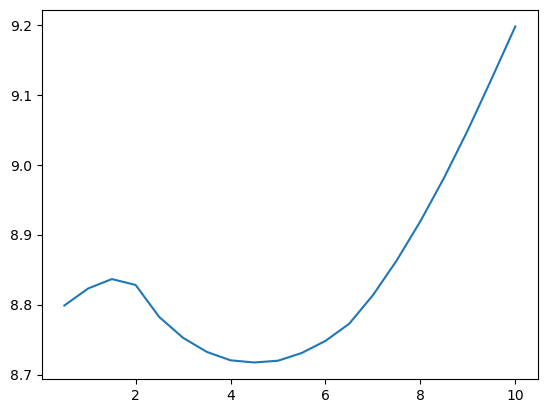

In [39]:
plt.plot(lasso_tuning_df["alpha"], lasso_tuning_df["rmse"])

In [40]:
print(f"Best rmse for lasso model is: {best_lasso_rmse} at alpha = {best_lasso_alpha}")

Best rmse for lasso model is: 8.717394661610083 at alpha = 4.5


In [41]:
# Retrain the lasso model on the train + valid data
feature_train_valid = pd.concat([feature_train, feature_valid], axis=0)
labels_train_valid = pd.concat([labels_train, labels_valid], axis=0)
lasso_models = {day:Lasso(alpha=best_lasso_alpha) for day in dow}
for day, lasso in lasso_models.items():
    lasso.fit(feature_train_valid, labels_train_valid[day])

In [42]:
lgbm_models = {day:LGBMRegressor() for day in dow}
for day, lgbr in lgbm_models.items():
    lgbr.fit(feature_train, labels_train[day], eval_set=(feature_valid, labels_valid[day]), 
        eval_metric="l2", callbacks=[early_stopping(10)])

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's l2: 163.029
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 149.719
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 150.572
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 279.157
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 200.164
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's l2: 438.283
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 213.092


In [43]:
pred_valid_lgbm = labels_valid[["cutoff_day", "enc_sku"]].copy()
for day in dow:
    pred_valid_lgbm[day] = lgbm_models[day].predict(feature_valid)
rmse_cal(labels_valid[dow] - pred_valid_lgbm[dow])

15.090276584340515

=> Best model is Lasso

# Evaluate model performance

In [44]:
all_models = {
    "lasso": lasso_models,
    "lr": lr_models,
    "lgbm": lgbm_models
}
all_models["lasso"]

{'mon': Lasso(alpha=4.5),
 'tue': Lasso(alpha=4.5),
 'wed': Lasso(alpha=4.5),
 'thu': Lasso(alpha=4.5),
 'fri': Lasso(alpha=4.5),
 'sat': Lasso(alpha=4.5),
 'sun': Lasso(alpha=4.5)}

In [45]:
dow_int_dict = {
    "mon":0,
    "tue":1,
    "wed":2,
    "thu":3,
    "fri":4,
    "sat":5,
    "sun":6,
}

In [46]:
data_test["dow"] = data_test["SALES_DATE"].dt.dayofweek
evaluation_df = data_test[["Encoded_SKU_ID","SALES_DATE","DAILY_UNITS", "dow"]]

In [47]:
for m_name, models in all_models.items():
    pred_test = labels_test[["cutoff_day", "enc_sku"]].copy()
    for day in dow:
        pred_test[day] = models[day].predict(feature_test)
    pt_flatten = pred_test.iloc[:,1:].set_index("enc_sku").unstack(level=1).reset_index(name=f"pred_{m_name}")
    pt_flatten["dow"] = pt_flatten["level_0"].map(dow_int_dict)
    pt_flatten.drop(columns=["level_0"], inplace=True)
    evaluation_df = pd.merge(evaluation_df, pt_flatten, how="left", 
        left_on=["Encoded_SKU_ID","dow"], right_on=["enc_sku", "dow"]).drop(columns=["enc_sku"])

evaluation_df
    


,Encoded_SKU_ID,SALES_DATE,DAILY_UNITS,dow,pred_lasso,pred_lr,pred_lgbm
0,23,2022-08-06,3,5,1.445562,0.830630,1.957345
1,100,2022-08-02,2,1,1.179585,0.702558,0.858658
2,121,2022-08-06,6,5,2.911855,2.238131,3.292423
3,207,2022-08-03,0,2,1.629639,0.782706,1.297696
4,416,2022-08-05,9,4,11.634306,10.913730,11.119518
...,...,...,...,...,...,...,...
3768,486,2022-08-06,2,5,3.594606,3.893050,3.668519
3769,171,2022-08-02,1,1,0.756767,0.728881,0.948401
3770,258,2022-08-01,0,0,0.659429,0.688133,0.838150
3771,140,2022-08-01,1,0,2.844260,0.214861,2.000656


===== lasso =====
lasso's rmse: 4.11714171373878
RMSE by SKU:
 count    539.000000
mean       1.947591
std        3.630730
min        0.310882
25%        0.953459
50%        1.312361
75%        1.909154
90%        3.151227
95%        3.734143
98%        6.016760
99%        9.067823
max       54.381753
dtype: float64


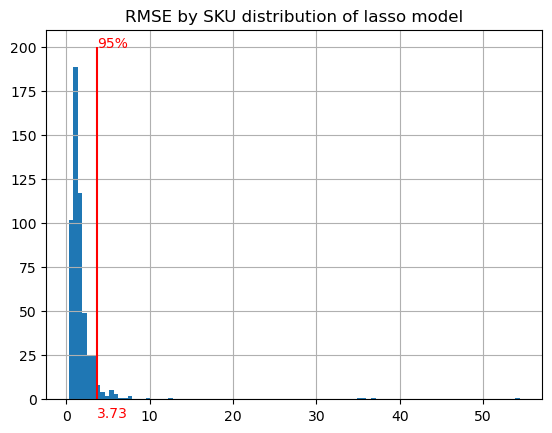

===== lr =====
lr's rmse: 8.624870966525808
RMSE by SKU:
 count    539.000000
mean       2.687448
std        8.203101
min        0.390869
25%        1.045267
50%        1.453768
75%        2.231015
90%        3.312321
95%        4.916655
98%        8.106807
99%       29.998551
max      117.573041
dtype: float64


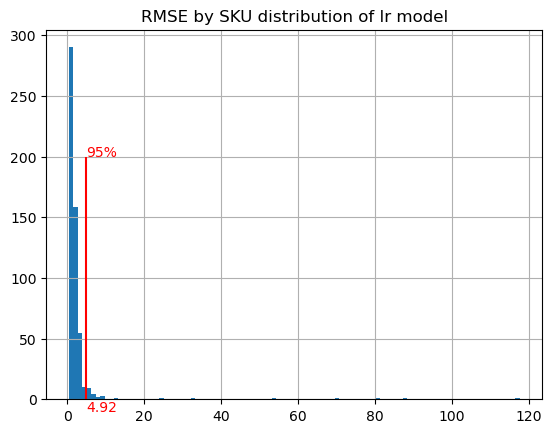

===== lgbm =====
lgbm's rmse: 15.092818308327239
RMSE by SKU:
 count    539.000000
mean       2.549953
std       14.889668
min        0.435608
25%        0.912522
50%        1.275905
75%        1.893450
90%        2.984222
95%        4.622142
98%       10.202285
99%       17.668843
max      340.031452
dtype: float64


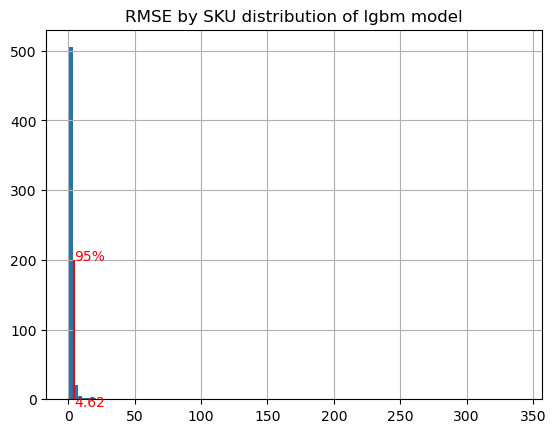

In [48]:
for m_name in all_models:
    print(f"===== {m_name} =====")
    rmse = mean_squared_error(evaluation_df["DAILY_UNITS"], evaluation_df[f"pred_{m_name}"], squared=False)
    print(f"{m_name}'s rmse: {rmse}")
    rmse_by_sku = evaluation_df.groupby("Encoded_SKU_ID").apply(lambda x: mean_squared_error(x["DAILY_UNITS"], x[f"pred_{m_name}"], squared=False))
    rmse_by_sku_desc = rmse_by_sku.describe(percentiles=[0.25,0.75,0.9,0.95,0.98,0.99])
    print("RMSE by SKU:\n", rmse_by_sku_desc)
    pct_thres = "95%"
    val_ = round(rmse_by_sku_desc[pct_thres],2)
    rmse_by_sku.hist(bins=100)
    plt.vlines(x=val_,ymin=0, ymax=200, colors="red")
    plt.text(x=val_, y=200, s=pct_thres, c="red")
    plt.text(x=val_, y=-10, s=val_, c="red")
    plt.title(f"RMSE by SKU distribution of {m_name} model")
    plt.show()
